## Import Packages and Load Data

In [0]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv')

df.head(5)

,Month,AirPassengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Our DataFrame clearly contains a **Month** and **AirPassengers** column. The Prophet library expects as input a DataFrame with one column containing the time information, and another column containing the metric that we wish to forecast. Importantly, the time column is expected to be of the **datetime** type, so let’s check the type of our columns:

Prophet also imposes the strict condition that the input columns be named **ds** (the time column) and **y** (the metric column), so let’s rename the columns in our DataFrame:

In [3]:
df = df.rename(columns={'Month': 'ds',
                        'AirPassengers': 'y'})

df.head(5)

,ds,y
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


It is good practice to visualize the data we are going to be working with, so let’s plot our time series:

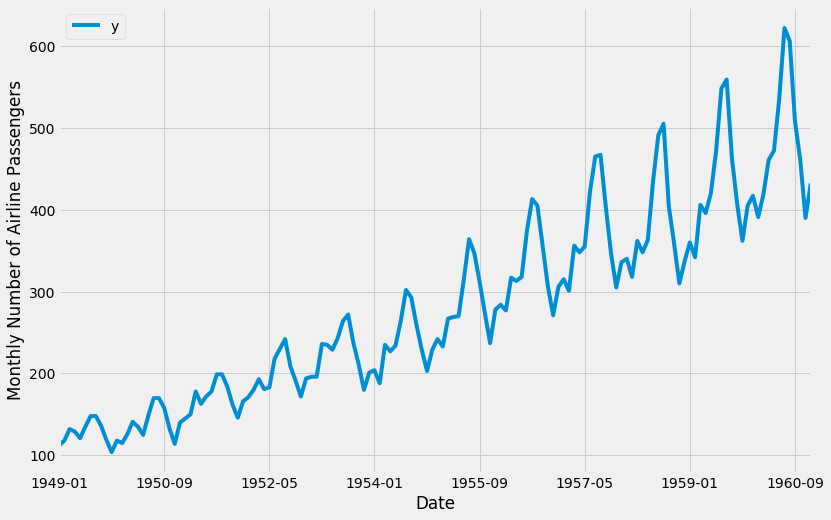

In [4]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

Because the **ds** column is not of the **datetime** type, we’ll need to convert it:

In [5]:
df['ds'] = pd.DatetimeIndex(df['ds'])
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [6]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

With our data now prepared, we are ready to use the Prophet library to produce forecasts of our time series.

## Time Series Forecasting with Prophet

In this section, we will describe how to use the Prophet library to predict future values of our time series. The authors of Prophet have abstracted away many of the inherent complexities of time series forecasting and made it more intuitive for analysts and developers alike to work with time series data.

To begin, we must instantiate a new Prophet object. Prophet enables us to specify a number of arguments. For example, we can specify the desired range of our uncertainty interval by setting the **interval_width** parameter.

In [0]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

Now that our Prophet model has been initialized, we can call its **fit** method with our DataFrame as input. The model fitting should take no longer than a few seconds.

In [8]:
my_model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In order to obtain forecasts of our time series, we must provide Prophet with a new DataFrame containing a **ds** column that holds the dates for which we want predictions. Conveniently, we do not have to concern ourselves with manually creating this DataFrame, as Prophet provides the **make_future_dataframe** helper function:

In [9]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


In the code chunk above, we instructed Prophet to generate 36 datestamps in the future.

When working with Prophet, it is important to consider the frequency of our time series. Because we are working with monthly data, we clearly specified the desired frequency of the timestamps (in this case, **MS** is the start of the month). Therefore, the **make_future_dataframe** generated 36 monthly timestamps for us. In other words, we are looking to predict future values of our time series 3 years into the future.

The DataFrame of future dates is then used as input to the **predict** method of our fitted model.

In [0]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:

* **ds**: the datestamp of the forecasted value
* **yhat**: the forecasted value of our metric (in Statistics, **yhat** is a notation traditionally used to represent the predicted values of a value y)
* **yhat_lower**: the lower bound of our forecasts
* **yhat_upper**: the upper bound of our forecasts

A variation in values from the output presented above is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time.

Prophet also provides a convenient function to quickly plot the results of our forecasts:

In [0]:
my_model.plot(forecast,
              uncertainty=True);

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values:

In [0]:
my_model.plot_components(forecast);

The plot above provides interesting insights. The first plot shows that the monthly volume of airline passengers has been linearly increasing over time. The second plot highlights the fact that the weekly count of passengers peaks towards the end of the week and on Saturday, while the third plot shows that the most traffic occurs during the holiday months of July and August.